# Data Modeling

In this notebook, I will model the credit risk dataset using three models:

    1. Logistic Regression
    2. K-Nearest Neighbor Model
    3. Decision Tree Classifier
    4. Catboost 
    
For each model:

    1. The train-test split will be 80%-20% 
    2. Accuracy of the models will be evaluated using accuracy score, classification report, and confusion matrix
    3. Hypertuning of the Parameters will be done using the RandomizedSearchCV
    4. For the Logistic Regression and Catboost models Feature Importance will be graphed and calulated
    5. Dataset will be filtered to borrowers who haven't defaulted before to see if the accuracy of the models change


In [3]:
! pip install catboost

# The Data & Cleanup

To start off it is important to important to upload the dataset, clean it, and see the data type of the columns in the dataset. Furthermore it is important to see if any columns have any null values, and ways in which we can fill those null values to make our model give the proper and most accurate results. 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics, neighbors, tree
import pydotplus
from catboost import CatBoostClassifier


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

In [6]:
df = pd.read_csv('credit risk.csv')

In [7]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [8]:
# Renaming Columns
df = df.rename(index=str, columns={"person_age":"Age", "person_income":"Income", "person_home_ownership":"home ownership", "person_emp_length":"Years_Employed","loan_intent":"intent","loan_amnt":"Amount","loan_int_rate":"Rate","loan_status":"Default","loan_percent_income":"Loan_Percent_Income","cb_person_default_on_file":"default on file","cb_person_cred_hist_length":"Credit_History","loan_grade":"grade"})

In [9]:
df.head()

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,default on file,Credit_History
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [10]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
0       22   59000           RENT           123.0         PERSONAL     D   
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income default on file  \
0       35000  16

In [11]:
df.dtypes

Age                      int64
Income                   int64
home ownership          object
Years_Employed         float64
intent                  object
grade                   object
Amount                   int64
Rate                   float64
Default                  int64
Loan_Percent_Income    float64
default on file         object
Credit_History           int64
dtype: object

In [14]:
df['Rate'].fillna((df['Rate'].median()), inplace=True)
df['Years_Employed'].fillna((df['Years_Employed'].median()), inplace=True)

In [15]:
df = df[df['Age']<100]

In [16]:
df = df[df['Years_Employed']<=40]

In [17]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income default on file  \
1        1000  11

# Creating Dummy Variables

By Looking at the data types of the columns in this dataset there are four columns that aren't numerical. They are intent, home ownership, grade, and default of file. These are the columns for which dummy variables will need to be created. Before doing that it important to see the value counts for these columns.

In [30]:
print(df['grade'].value_counts())

A    10775
B    10448
C     6456
D     3625
E      964
F      241
G       64
Name: grade, dtype: int64


In [31]:
print(df['intent'].value_counts())

EDUCATION            6451
MEDICAL              6070
VENTURE              5716
PERSONAL             5519
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: intent, dtype: int64


In [32]:
print(df['home ownership'].value_counts())

RENT        16441
MORTGAGE    13441
OWN          2584
OTHER         107
Name: home ownership, dtype: int64


In [33]:
print(df['default on file'].value_counts())

N    26829
Y     5744
Name: default on file, dtype: int64


In [34]:
Features = ['grade', 'intent', 'home ownership', 'default on file']
df_features = df[Features]

In [36]:
dummy = pd.get_dummies(df_features, drop_first=True)

In [37]:
dummy.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [38]:
df = pd.concat([df, dummy], axis=1)

In [39]:
print(df)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
4       24   54400           RENT             8.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income  ... grade_G  \
1        1000  11.14

In [40]:
cor = df.corr(method = 'spearman')['Default'].sort_values(ascending =False)
print(cor)

Default                   1.000000
grade_D                   0.318865
Loan_Percent_Income       0.316034
Rate                      0.297993
home ownership_RENT       0.238437
grade_E                   0.180128
default on file_Y         0.178995
grade_F                   0.101845
Amount                    0.083970
grade_G                   0.082311
intent_MEDICAL            0.056620
intent_HOMEIMPROVEMENT    0.036591
home ownership_OTHER      0.012541
grade_C                  -0.012980
intent_PERSONAL          -0.021236
Credit_History           -0.023736
Age                      -0.033144
intent_EDUCATION         -0.055307
intent_VENTURE           -0.078197
grade_B                  -0.092144
Years_Employed           -0.094748
home ownership_OWN       -0.101986
Income                   -0.272089
Name: Default, dtype: float64


# Data Distribution

The next step is to see how the nuemrical data is distributed and see if what if any kind of scalling is necessary for pre-processing.

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

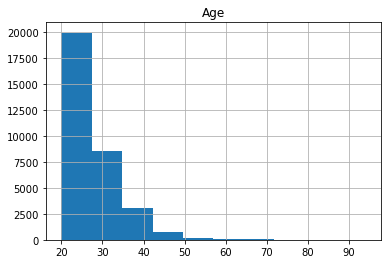

In [41]:
df.hist(column = 'Age')

array([[<AxesSubplot:title={'center':'Years_Employed'}>]], dtype=object)

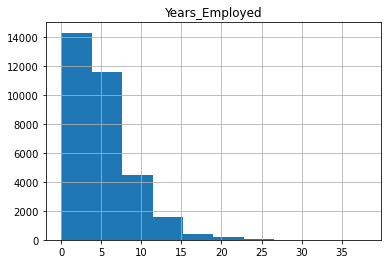

In [42]:
df.hist(column = 'Years_Employed')

array([[<AxesSubplot:title={'center':'Rate'}>]], dtype=object)

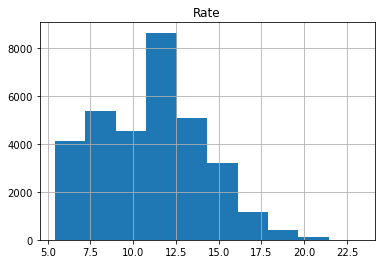

In [43]:
df.hist(column = 'Rate')

array([[<AxesSubplot:title={'center':'Credit_History'}>]], dtype=object)

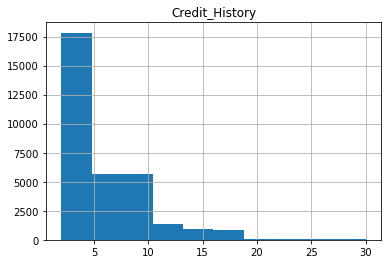

In [44]:
df.hist(column = 'Credit_History')

array([[<AxesSubplot:title={'center':'Amount'}>]], dtype=object)

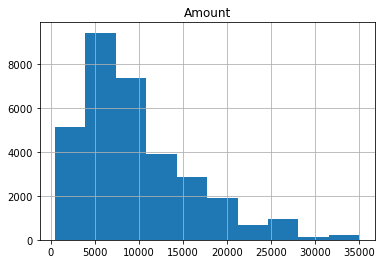

In [45]:
df.hist(column = 'Amount')

array([[<AxesSubplot:title={'center':'Loan_Percent_Income'}>]],
      dtype=object)

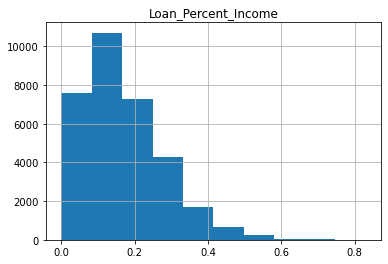

In [46]:
df.hist(column = 'Loan_Percent_Income')

array([[<AxesSubplot:title={'center':'Income'}>]], dtype=object)

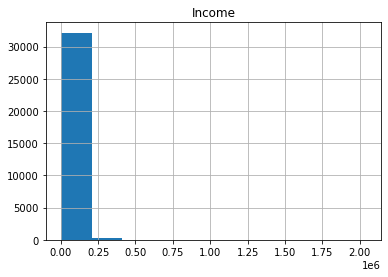

In [47]:
df.hist(column = 'Income')

In [49]:
df.describe()

,Age,Income,Years_Employed,Amount,Rate,Default,Loan_Percent_Income,Credit_History,grade_B,grade_C,...,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
count,32573.000000,3.257300e+04,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,...,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000
mean,27.716882,6.587903e+04,4.781161,9588.220305,11.009577,0.218187,0.170205,5.803518,0.320756,0.198201,...,0.001965,0.198047,0.110674,0.186351,0.169435,0.175483,0.003285,0.079330,0.504743,0.176342
std,6.198825,5.253265e+04,3.974126,6320.241199,3.081650,0.413021,0.106755,4.052540,0.466775,0.398650,...,0.044283,0.398534,0.313733,0.389395,0.375141,0.380385,0.057221,0.270257,0.499985,0.381117
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,94.000000,2.039784e+06,38.000000,35000.000000,23.220000,1.000000,0.830000,30.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Modeling

## Train/Split Data

Before we model out data it is import to split the data into train and test sets. I will use a 80-20 Train-test split.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Default'), 
                                                    df.Default, test_size=0.2, 
                                                    random_state=50)

In [79]:
X_train.dtypes


Age                         int64
Income                      int64
home ownership             object
Years_Employed            float64
intent                     object
grade                      object
Amount                      int64
Rate                      float64
Loan_Percent_Income       float64
default on file            object
Credit_History              int64
grade_B                     uint8
grade_C                     uint8
grade_D                     uint8
grade_E                     uint8
grade_F                     uint8
grade_G                     uint8
intent_EDUCATION            uint8
intent_HOMEIMPROVEMENT      uint8
intent_MEDICAL              uint8
intent_PERSONAL             uint8
intent_VENTURE              uint8
home ownership_OTHER        uint8
home ownership_OWN          uint8
home ownership_RENT         uint8
default on file_Y           uint8
dtype: object

In [80]:
X_test.dtypes

Age                         int64
Income                      int64
home ownership             object
Years_Employed            float64
intent                     object
grade                      object
Amount                      int64
Rate                      float64
Loan_Percent_Income       float64
default on file            object
Credit_History              int64
grade_B                     uint8
grade_C                     uint8
grade_D                     uint8
grade_E                     uint8
grade_F                     uint8
grade_G                     uint8
intent_EDUCATION            uint8
intent_HOMEIMPROVEMENT      uint8
intent_MEDICAL              uint8
intent_PERSONAL             uint8
intent_VENTURE              uint8
home ownership_OTHER        uint8
home ownership_OWN          uint8
home ownership_RENT         uint8
default on file_Y           uint8
dtype: object

In [81]:
# Dropping object columns
names_list = ['home ownership', 'intent', 'grade', 'default on file']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)


## Logistic Regression

In [82]:
LG = LogisticRegression()

LG.fit(X_train, y_train)



LogisticRegression()

In [83]:
# Intercept of Logistic Regression

LG.intercept_[0]

-2.148416749067799e-09

In [84]:
# Coefficients of Logistic Regression

LG.coef_[0]

array([-5.18931663e-08, -4.06783915e-05, -2.45179014e-08,  1.06479971e-04,
        8.48250139e-08,  2.62841269e-09, -7.56052227e-09, -5.55508467e-09,
       -1.22181467e-09,  1.08548397e-08,  3.38420324e-09,  9.89860446e-10,
        4.05365643e-10, -2.91035222e-09,  1.68541017e-09,  1.23392867e-09,
       -1.06083726e-09, -3.65533973e-09,  9.67316755e-11, -4.04728858e-09,
        8.18999973e-09,  7.02606159e-09])

In [85]:
LG.score(X_test, y_test)

0.8033768227168073

In [86]:
# Confusion Matrix For Logistic Regression
y_LG_Pred = LG.predict(X_test)
LG_CM = confusion_matrix(y_test, y_LG_Pred)
print(LG_CM)

[[5005   90]
 [1191  229]]


In [87]:
# Classfication Report for Logistic Regression

print(classification_report(y_test,y_LG_Pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5095
           1       0.72      0.16      0.26      1420

    accuracy                           0.80      6515
   macro avg       0.76      0.57      0.57      6515
weighted avg       0.79      0.80      0.75      6515



In [88]:
# Training and Test Accuracy for Logistic regression

Training_accuracy = LG.score(X_train, y_train)
Testing_accuracy = LG.score(X_test, y_test)

print("Training accuracy of Logistic Regression model is:{:0.2f}".format(Training_accuracy))

print("Testing accuracy of Logistic Regression model is:{:0.2f}".format(Testing_accuracy))




Training accuracy of Logistic Regression model is:0.80
Testing accuracy of Logistic Regression model is:0.80


Text(0.5, 1.0, 'Permutation Importance')

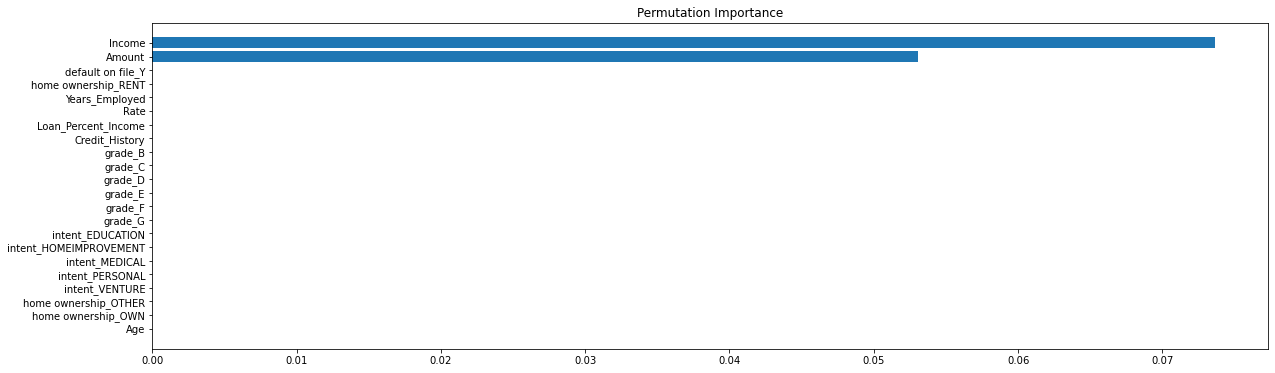

In [89]:
# Feature Importance For Logistic Regression

model_LG = LG.fit(X_train, y_train)

FI_LG =  permutation_importance(model_LG, X_test, y_test, n_repeats=30, random_state=0)

sorted_idx_LG = FI_LG.importances_mean.argsort()


fig = plt.figure(figsize=(20, 6))
plt.barh(range(len(sorted_idx_LG)), FI_LG.importances_mean[sorted_idx_LG], align='center')
plt.yticks(range(len(sorted_idx_LG)), np.array(X_test.columns)[sorted_idx_LG])
plt.title('Permutation Importance')


Based on the results of the accuracy score, it seems that our Logistic Regression model, give us 80% accuracy. While this is a relative high accuracy, it is also important to explore other models to see if they would have a higher accuracy. The Logistic Regression model also relies heavily on the income of borrower and loan amount to make accurate prediction about default.

## kNN Model

In [90]:
kNN = KNeighborsClassifier(n_neighbors=150)

kNN.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=150)

In [91]:
kNN.score(X_test, y_test)

0.8359171143514965

In [92]:
y_kNN_Pred = kNN.predict(X_test)
kNN_CM = confusion_matrix(y_test, y_kNN_Pred)
print(kNN_CM)

[[4901  194]
 [ 875  545]]


In [93]:
print(classification_report(y_test,y_kNN_Pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5095
           1       0.74      0.38      0.50      1420

    accuracy                           0.84      6515
   macro avg       0.79      0.67      0.70      6515
weighted avg       0.82      0.84      0.82      6515



In [94]:
# Training and Test Accuracy for kNN

Training_accuracy_kNN = kNN.score(X_train, y_train)
Testing_accuracy_kNN = kNN.score(X_test, y_test)

print("Training accuracy of kNN model is:{:0.2f}".format(Training_accuracy_kNN))

print("Testing accuracy of kNN model is:{:0.2f}".format(Testing_accuracy_kNN))




Training accuracy of kNN model is:0.84
Testing accuracy of kNN model is:0.84


Based on the results of the accuracy score, it seems that the kNN model, give us 84% accuracy. While this is higher than the Logistic Regression Model, it is important to test out the Decision Tree Classifier model.

## Decision Tree Classifier

For the Decision Tree, two models will be used: Entrophy and Gini. 

In [95]:
# entrophy Decision Tree
DT_1 = DecisionTreeClassifier(criterion="entropy", random_state = 1234)

DT_1.fit(X_train, y_train)



DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [96]:
DT_1.score(X_test, y_test)

0.8990023023791252

In [97]:
y_DT_1_Pred = DT_1.predict(X_test)
DT_1_CM = confusion_matrix(y_test, y_DT_1_Pred)
print(DT_1_CM)

[[4746  349]
 [ 309 1111]]


In [98]:
print(classification_report(y_test,y_DT_1_Pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5095
           1       0.76      0.78      0.77      1420

    accuracy                           0.90      6515
   macro avg       0.85      0.86      0.85      6515
weighted avg       0.90      0.90      0.90      6515



In [99]:

Training_accuracy_DT_1 = DT_1.score(X_train, y_train)
Testing_accuracy_DT_1 = DT_1.score(X_test, y_test)

print("Training accuracy of Decision Tree with Entrophy model is:{:0.2f}".format(Training_accuracy_DT_1))

print("Testing accuracy of Decision Tree with Entrophy model is:{:0.2f}".format(Testing_accuracy_DT_1))




Training accuracy of Decision Tree with Entrophy model is:1.00
Testing accuracy of Decision Tree with Entrophy model is:0.90


Using the Decision Tree classifier with the entrophy method has an accuracy of 90%

In [100]:
#Gini Decision Tree

# entrophy Decision Tree
DT_2 = DecisionTreeClassifier(criterion="gini", random_state = 1234)

DT_2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [101]:
DT_2.score(X_test, y_test)

0.8867229470452801

In [102]:
y_DT_2_Pred = DT_2.predict(X_test)
DT_2_CM = confusion_matrix(y_test, y_DT_2_Pred)
print(DT_2_CM)

[[4691  404]
 [ 334 1086]]


In [103]:
print(classification_report(y_test,y_DT_2_Pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5095
           1       0.73      0.76      0.75      1420

    accuracy                           0.89      6515
   macro avg       0.83      0.84      0.84      6515
weighted avg       0.89      0.89      0.89      6515



In [104]:
Training_accuracy_DT_2 = DT_2.score(X_train, y_train)
Testing_accuracy_DT_2 = DT_2.score(X_test, y_test)

print("Training accuracy of Decision Tree with Gini model is:{:0.2f}".format(Training_accuracy_DT_2))

print("Testing accuracy of Decision Tree with Gini model is:{:0.2f}".format(Testing_accuracy_DT_2))

Training accuracy of Decision Tree with Gini model is:1.00
Testing accuracy of Decision Tree with Gini model is:0.89


It seems that the decision tree model, is the most accurate of the three.

## Catboost

In [108]:
cat = CatBoostClassifier(iterations=500, verbose=100,eval_metric="Recall")

cat.fit(X_train, y_train)

Learning rate set to 0.078268
0:	learn: 0.5660278	total: 15ms	remaining: 7.47s
100:	learn: 0.7167223	total: 957ms	remaining: 3.78s
200:	learn: 0.7309654	total: 1.85s	remaining: 2.76s
300:	learn: 0.7438017	total: 2.77s	remaining: 1.83s
400:	learn: 0.7578688	total: 3.69s	remaining: 910ms
499:	learn: 0.7708810	total: 4.56s	remaining: 0us


In [109]:
cat.score(X_test, y_test)

0.9364543361473523

In [110]:
y_cat_Pred = cat.predict(X_test)
cat_CM = confusion_matrix(y_test, y_cat_Pred)
print(cat_CM)

[[5067   28]
 [ 386 1034]]


In [111]:
print(classification_report(y_test,y_cat_Pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.73      0.83      1420

    accuracy                           0.94      6515
   macro avg       0.95      0.86      0.90      6515
weighted avg       0.94      0.94      0.93      6515



In [113]:
Training_accuracy_cat = cat.score(X_train, y_train)
Testing_accuracy_cat = cat.score(X_test, y_test)

print("Training accuracy of CatBoost is:{:0.2f}".format(Training_accuracy_cat))

print("Testing accuracy of CatBoost is:{:0.2f}".format(Testing_accuracy_cat))

Training accuracy of CatBoost is:0.95
Testing accuracy of CatBoost is:0.94


Learning rate set to 0.078268
0:	learn: 0.5660278	total: 9.79ms	remaining: 4.89s
100:	learn: 0.7167223	total: 932ms	remaining: 3.68s
200:	learn: 0.7309654	total: 1.84s	remaining: 2.73s
300:	learn: 0.7438017	total: 2.74s	remaining: 1.81s
400:	learn: 0.7578688	total: 3.63s	remaining: 896ms
499:	learn: 0.7708810	total: 4.53s	remaining: 0us


Text(0.5, 1.0, 'Permutation Importance')

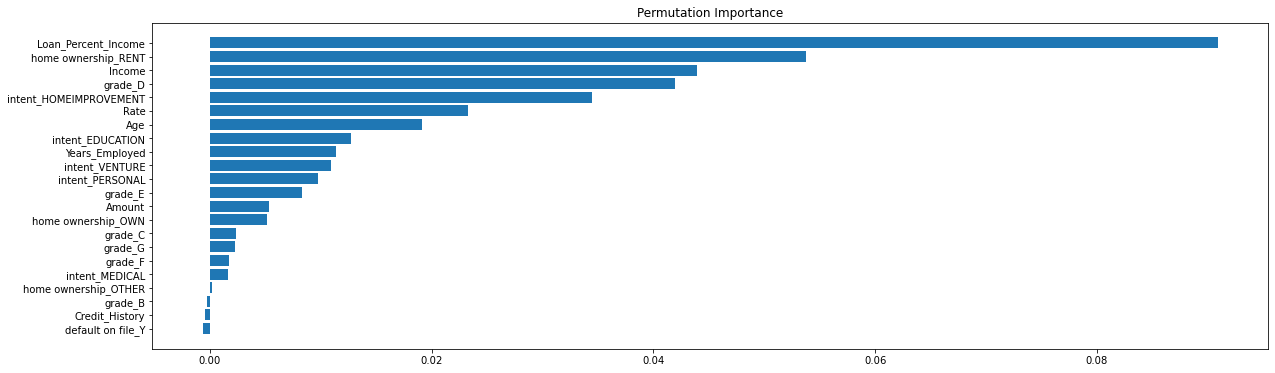

In [114]:
#Feature Importance of CatBoost

model_cat = cat.fit(X_train, y_train)

FI_cat =  permutation_importance(model_cat, X_test, y_test, n_repeats=30, random_state=0)

sorted_idx_cat = FI_cat.importances_mean.argsort()


fig = plt.figure(figsize=(20, 6))
plt.barh(range(len(sorted_idx_cat)), FI_cat.importances_mean[sorted_idx_cat], align='center')
plt.yticks(range(len(sorted_idx_cat)), np.array(X_test.columns)[sorted_idx_cat])
plt.title('Permutation Importance')


With Catboost the accuracy is even higher at 95%. Furthermore, it has more features than the Logistic Regression model that are important. Loan(% of Income), Income, Interest rate, Age, whether or not the loan was a D, and Years employed, seem to have the most importance in this model. Surprisingly years of Credit History and whether or not a person defaulted on a loan before do not.

## ROC-AUC Curves

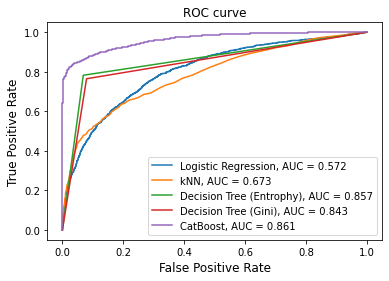

In [137]:
#ROC-AUC For all models

# Logistic Regression
Log_ROC = roc_auc_score(y_test, y_LG_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, LG.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(Log_ROC,3))}')

#kNN
kNN_ROC = roc_auc_score(y_test, y_kNN_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, kNN.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'kNN, AUC = {str(round(kNN_ROC,3))}')

#Decision Tree with entrophy
DT_1_ROC = roc_auc_score(y_test, y_DT_1_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, DT_1.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Entrophy), AUC = {str(round(DT_1_ROC,3))}')

#Decision Tree with gini
DT_2_ROC = roc_auc_score(y_test, y_DT_2_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, DT_2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Gini), AUC = {str(round(DT_2_ROC,3))}')


#CatBoost
Cat_ROC = roc_auc_score(y_test, y_cat_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_test, cat.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'CatBoost, AUC = {str(round(Cat_ROC,3))}')


plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.legend()
plt.show()

Based on the ROC-AUC Curve shown is seems that the best model is the CatBoost model.

# Hypertuning Parameters

In [76]:
#Logistic Regression
param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.1, 1, 10, 100]}

LG_cv = RandomizedSearchCV(LG, param_grid, cv=5)

LG_cv.fit(X_train, y_train)

LG_cv.best_params_

LG_cv.best_score_

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

0.8039372332539954

In [79]:
#kNN
param_grid_knn = {'n_neighbors':np.arange(1,50)}
KNN = KNeighborsClassifier()
kNN_CV = RandomizedSearchCV(KNN, param_grid_knn, cv=5)
kNN_CV.fit(X_train, y_train)

print("Best Score:" + str(kNN_CV.best_score_))
print("Best Parameters: " + str(kNN_CV.best_params_))


Best Score:0.8394735264692598
Best Parameters: {'n_neighbors': 42}


In [78]:
# Decision Tree

param_grid_DT = {'max_depth': [2, 3, 5, 10, 20],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini", "entropy"]}


DT = DecisionTreeClassifier()
DT_CV = RandomizedSearchCV(DT, param_grid_DT, cv=5)
DT_CV.fit(X_train, y_train)


print("Best Score:" + str(DT_CV.best_score_))
print("Best Parameters: " + str(DT_CV.best_params_))


Best Score:0.9219052308763576
Best Parameters: {'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'gini'}


In [117]:
# CatBoost

param_grid_cat = {'depth':[6,8,10], 'learning_rate':[0.01, 0.05, 0.1],'iterations':[30, 50, 100]}


CAT = CatBoostClassifier()
CAT_CV = RandomizedSearchCV(CAT, param_grid_cat, cv = 2, n_jobs=-1)
CAT_CV.fit(X_train, y_train)


print("Best Score:" + str(CAT_CV.best_score_))
print("Best Parameters: " + str(CAT_CV.best_params_))



0:	learn: 0.5936543	total: 18.1ms	remaining: 1.79s
1:	learn: 0.5130868	total: 69.8ms	remaining: 3.42s
2:	learn: 0.4473068	total: 119ms	remaining: 3.84s
3:	learn: 0.3988298	total: 173ms	remaining: 4.16s
4:	learn: 0.3706903	total: 222ms	remaining: 4.22s
5:	learn: 0.3423076	total: 263ms	remaining: 4.12s
6:	learn: 0.3217056	total: 325ms	remaining: 4.31s
7:	learn: 0.3021748	total: 369ms	remaining: 4.24s
8:	learn: 0.2897889	total: 418ms	remaining: 4.22s
9:	learn: 0.2779882	total: 454ms	remaining: 4.08s
10:	learn: 0.2673024	total: 485ms	remaining: 3.93s
11:	learn: 0.2594228	total: 516ms	remaining: 3.78s
12:	learn: 0.2541920	total: 541ms	remaining: 3.62s
13:	learn: 0.2484879	total: 565ms	remaining: 3.47s
14:	learn: 0.2433457	total: 591ms	remaining: 3.35s
15:	learn: 0.2399727	total: 616ms	remaining: 3.23s
16:	learn: 0.2353416	total: 642ms	remaining: 3.13s
17:	learn: 0.2321869	total: 667ms	remaining: 3.04s
18:	learn: 0.2295432	total: 694ms	remaining: 2.96s
19:	learn: 0.2267518	total: 720ms	remai

Based on the Hyperparameter Tuning using Randomized Grid Search CV, the following conclusions can be drawn:

1. Even with hyperparameter tuning, the best accuracy that the Logistic Regression can have is 80%. Which means that the Logistic Regression used is the best one

2. For the Decision Tree classifier the best method to use is entropy with a max depth of 20

3. For kNN the best number of neighbors is 32

4. For CatBoost the best score is 93%, the best learning rate is 0.1 with 100 iterations and a depth of 10

# Alternate Modeling Excluding Borrowers Who Defaulted Before

The previous models included all borrowers, even those that had defaulted before. Therefore it important to model borrowers that didn't default before only. It is important to this type of modeling as these are borrowers who either have little to no credit history or have haven't defaulted. This will give us true representation of what the risk is associated with loans given out to borrower, as we don't know for certain if that borrower will default or not.

In [119]:
df.head()

,Age,Income,home ownership,Years_Employed,intent,grade,Amount,Rate,Default,Loan_Percent_Income,...,grade_G,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,home ownership_OTHER,home ownership_OWN,home ownership_RENT,default on file_Y
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,1,0,0,0,0,0,1,0,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,1,0,0,0,0,0,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,0,1,0,0,0,0,1,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,...,0,0,0,0,0,1,0,1,0,0


In [120]:
df_ND = df[df['default on file_Y'] == 0]

In [121]:
print(df_ND)

       Age  Income home ownership  Years_Employed           intent grade  \
1       21    9600            OWN             5.0        EDUCATION     B   
2       25    9600       MORTGAGE             1.0          MEDICAL     C   
3       23   65500           RENT             4.0          MEDICAL     C   
5       21    9900            OWN             2.0          VENTURE     A   
6       26   77100           RENT             8.0        EDUCATION     B   
...    ...     ...            ...             ...              ...   ...   
32576   57   53000       MORTGAGE             1.0         PERSONAL     C   
32577   54  120000       MORTGAGE             4.0         PERSONAL     A   
32578   65   76000           RENT             3.0  HOMEIMPROVEMENT     B   
32579   56  150000       MORTGAGE             5.0         PERSONAL     B   
32580   66   42000           RENT             2.0          MEDICAL     B   

       Amount   Rate  Default  Loan_Percent_Income  ... grade_G  \
1        1000  11.14

In [122]:
X_ND_train, X_ND_test, y_ND_train, y_ND_test = train_test_split(df_ND.drop(columns='Default'), 
                                                    df_ND.Default, test_size=0.2, 
                                                    random_state=50)

In [123]:
names_list = ['home ownership', 'intent', 'grade', 'default on file']
names_train = X_ND_train[names_list]
names_test = X_ND_test[names_list]
X_ND_train.drop(columns=names_list, inplace=True)
X_ND_test.drop(columns=names_list, inplace=True)


## Logistic Regression For Non-Deafult

In [124]:
# Logistic Regression

LG_ND = LogisticRegression()

LG_ND.fit(X_ND_train, y_ND_train)

LogisticRegression()

In [125]:
# Accuracy score for logistic Regression for non-default borrowers

LG_ND.score(X_ND_test, y_ND_test)

0.8524040253447633

In [126]:
# Confusion Matrix for Logistic Regression for non-default borrowers

y_LG_ND_Pred = LG_ND.predict(X_ND_test)
LG_ND_CM = confusion_matrix(y_ND_test, y_LG_ND_Pred)
print(LG_ND_CM)

[[4328   95]
 [ 697  246]]


In [127]:
# Classification Report for Logistic Regression for non-default borrowers
print(classification_report(y_ND_test,y_LG_ND_Pred))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4423
           1       0.72      0.26      0.38       943

    accuracy                           0.85      5366
   macro avg       0.79      0.62      0.65      5366
weighted avg       0.84      0.85      0.82      5366



Text(0.5, 1.0, 'Permutation Importance')

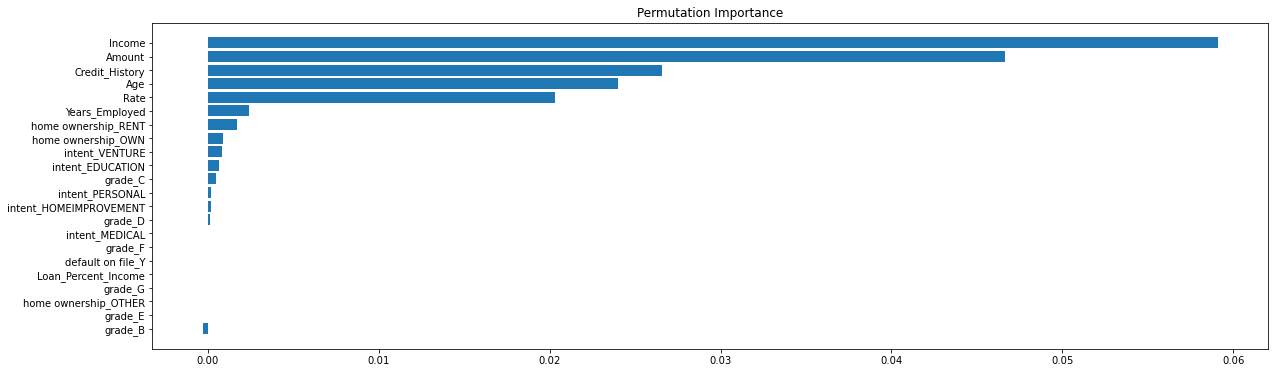

In [129]:
model_ND_LG = LG.fit(X_ND_train, y_ND_train)

FI_LG_ND =  permutation_importance(model_ND_LG, X_ND_test, y_ND_test, n_repeats=30, random_state=0)

sorted_idx_LG_ND = FI_LG_ND.importances_mean.argsort()


fig = plt.figure(figsize=(20, 6))
plt.barh(range(len(sorted_idx_LG_ND)), FI_LG_ND.importances_mean[sorted_idx_LG_ND], align='center')
plt.yticks(range(len(sorted_idx_LG_ND)), np.array(X_ND_test.columns)[sorted_idx_LG_ND])
plt.title('Permutation Importance')

By excluding borrowers who have defaulted before the accuracy of the Logistic Regression increased. In addition, other fetures are now important such as credit history, interest rate, years employed and whether or not the borrower is renting.

## kNN For Non-Defaulters 

In [139]:
# fitting kNN TO Non-default borrowers
kNN.fit(X_ND_train, y_ND_train)

KNeighborsClassifier(n_neighbors=150)

In [140]:
# Accuracy score of kNN for non-default borrowers

kNN.score(X_ND_test, y_ND_test)

0.8715989563920984

In [141]:
# Confusion Matrix for kNN  for non-default borrowers

y_kNN_ND_Pred = kNN.predict(X_ND_test)
kNN_ND_CM = confusion_matrix(y_ND_test, y_kNN_ND_Pred)
print(kNN_ND_CM)

[[4269  154]
 [ 535  408]]


In [142]:
# Classification Report for kNN for non-default borrowers
print(classification_report(y_ND_test,y_kNN_ND_Pred))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4423
           1       0.73      0.43      0.54       943

    accuracy                           0.87      5366
   macro avg       0.81      0.70      0.73      5366
weighted avg       0.86      0.87      0.86      5366



## Decision Tree Models for Non-Defaulters

In [143]:
# fitting Decision Tree with entropy To Non-default borrowers
DT_1.fit(X_ND_train, y_ND_train)

DecisionTreeClassifier(criterion='entropy', random_state=1234)

In [144]:
# Accuracy score of Decision Tree with entropy for non-default borrowers

DT_1.score(X_ND_test, y_ND_test)

0.9030935519940365

In [145]:
# Confusion Matrix of Decision Tree with entropy for non-default borrowers

y_DT_1_ND_Pred = DT_1.predict(X_ND_test)
DT_1_ND_CM = confusion_matrix(y_ND_test, y_DT_1_ND_Pred)
print(DT_1_ND_CM)

[[4144  279]
 [ 241  702]]


In [146]:
# Classification Report of Decision Tree with entropy for non-default borrowers
print(classification_report(y_ND_test,y_DT_1_ND_Pred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4423
           1       0.72      0.74      0.73       943

    accuracy                           0.90      5366
   macro avg       0.83      0.84      0.84      5366
weighted avg       0.90      0.90      0.90      5366



In [147]:
# fitting Decision Tree with Gini To Non-default borrowers
DT_2.fit(X_ND_train, y_ND_train)

DecisionTreeClassifier(random_state=1234)

In [148]:
# Accuracy score of Decision Tree with Gini for non-default borrowers

DT_2.score(X_ND_test, y_ND_test)

0.8956392098397317

In [149]:
# Confusion Matrix of Decision Tree with Gini for non-default borrowers

y_DT_2_ND_Pred = DT_2.predict(X_ND_test)
DT_2_ND_CM = confusion_matrix(y_ND_test, y_DT_2_ND_Pred)
print(DT_2_ND_CM)

[[4094  329]
 [ 231  712]]


In [150]:
# Classification Report of Decision Tree with Gini for non-default borrowers
print(classification_report(y_ND_test,y_DT_2_ND_Pred))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4423
           1       0.68      0.76      0.72       943

    accuracy                           0.90      5366
   macro avg       0.82      0.84      0.83      5366
weighted avg       0.90      0.90      0.90      5366



## CatBoost For Non-Defaulters 

In [130]:
cat.fit(X_ND_train, y_ND_train)

Learning rate set to 0.072046
0:	learn: 0.5351866	total: 13.5ms	remaining: 6.71s
100:	learn: 0.6972201	total: 556ms	remaining: 2.2s
200:	learn: 0.7150013	total: 1.13s	remaining: 1.68s
300:	learn: 0.7277736	total: 1.7s	remaining: 1.12s
400:	learn: 0.7407964	total: 2.3s	remaining: 567ms
499:	learn: 0.7535687	total: 2.88s	remaining: 0us


In [131]:
cat.score(X_ND_test, y_ND_test)

0.9459560193812896

In [132]:
y_cat_ND_Pred = cat.predict(X_ND_test)
cat_ND_CM = confusion_matrix(y_ND_test, y_cat_ND_Pred)
print(cat_ND_CM)

[[4410   13]
 [ 277  666]]


In [133]:
print(classification_report(y_ND_test,y_cat_ND_Pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4423
           1       0.98      0.71      0.82       943

    accuracy                           0.95      5366
   macro avg       0.96      0.85      0.89      5366
weighted avg       0.95      0.95      0.94      5366



In [134]:
Training_accuracy_cat_ND = cat.score(X_ND_train, y_ND_train)
Testing_accuracy_cat_ND = cat.score(X_ND_test, y_ND_test)

print("Training accuracy of CatBoost for non-defaulters is:{:0.2f}".format(Training_accuracy_cat_ND))

print("Testing accuracy of CatBoost for non-defaulters is:{:0.2f}".format(Testing_accuracy_cat_ND))

Training accuracy of CatBoost for non-defaulters is:0.95
Testing accuracy of CatBoost for non-defaulters is:0.95


Learning rate set to 0.072046
0:	learn: 0.5351866	total: 10.6ms	remaining: 5.26s
100:	learn: 0.6972201	total: 574ms	remaining: 2.27s
200:	learn: 0.7150013	total: 1.14s	remaining: 1.7s
300:	learn: 0.7277736	total: 1.7s	remaining: 1.12s
400:	learn: 0.7407964	total: 2.27s	remaining: 561ms
499:	learn: 0.7535687	total: 2.83s	remaining: 0us


Text(0.5, 1.0, 'Permutation Importance')

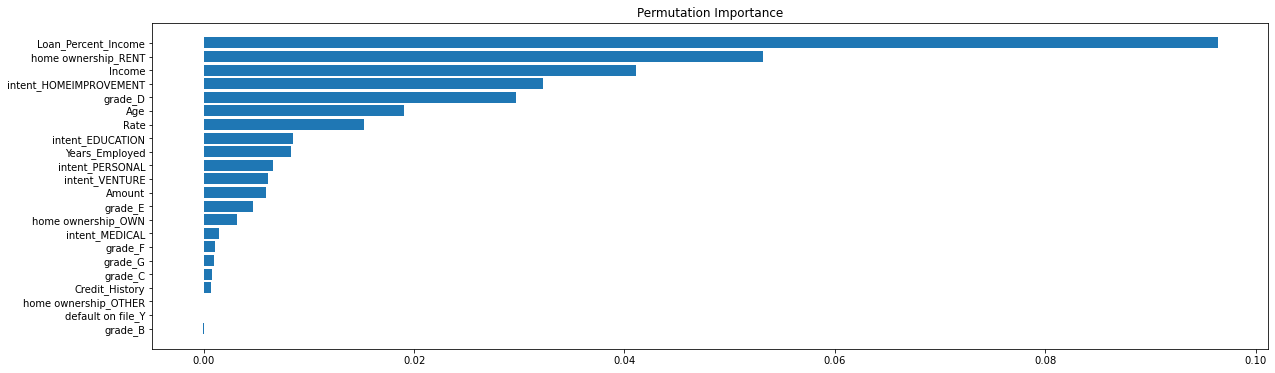

In [136]:
#Feature Importance of CatBoost for non-defaulters

model_cat_ND = cat.fit(X_ND_train, y_ND_train)

FI_cat_ND =  permutation_importance(model_cat_ND, X_ND_test, y_ND_test, n_repeats=30, random_state=0)

sorted_idx_cat_ND = FI_cat_ND.importances_mean.argsort()


fig = plt.figure(figsize=(20, 6))
plt.barh(range(len(sorted_idx_cat)), FI_cat_ND.importances_mean[sorted_idx_cat_ND], align='center')
plt.yticks(range(len(sorted_idx_cat_ND)), np.array(X_ND_test.columns)[sorted_idx_cat_ND])
plt.title('Permutation Importance')


For CatBoost Model, the accuracy doesn't change much nor does the feature importance of any of features. 

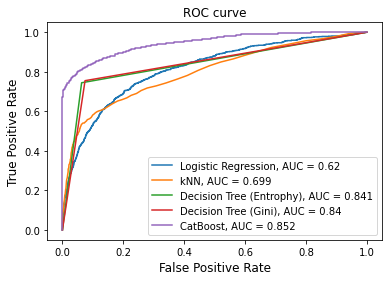

In [151]:
# ROC-AUC Curve for Non-Deafult borrowers

# Logistic Regression
Log_ND_ROC = roc_auc_score(y_ND_test, y_LG_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, LG.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(Log_ND_ROC,3))}')

#kNN
kNN_ND_ROC = roc_auc_score(y_ND_test, y_kNN_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, kNN.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'kNN, AUC = {str(round(kNN_ND_ROC,3))}')

#Decision Tree with entrophy
DT_1_ND_ROC = roc_auc_score(y_ND_test, y_DT_1_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, DT_1.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Entrophy), AUC = {str(round(DT_1_ND_ROC,3))}')

#Decision Tree with gini
DT_2_ND_ROC = roc_auc_score(y_ND_test, y_DT_2_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, DT_2.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'Decision Tree (Gini), AUC = {str(round(DT_2_ND_ROC,3))}')

#CatBoost
Cat_ND_ROC = roc_auc_score(y_ND_test, y_cat_ND_Pred)
fpr, tpr, thresh = metrics.roc_curve(y_ND_test, cat.predict_proba(X_ND_test)[:,1])
plt.plot(fpr, tpr, label=f'CatBoost, AUC = {str(round(Cat_ND_ROC,3))}')




plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.legend()
plt.show()

Removing the borrowers who had defaulted before improved the accuracy of the Logistic Regression and the nearest neighbor models. The accuracy of the decision tree models and CatBoost have remained the same.

## Hypertuning Parameters For non-deafulters

In [102]:
#Logistic Regression
param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.1, 1, 10, 100]}

LG_cv = RandomizedSearchCV(LG, param_grid, cv=5)

LG_cv.fit(X_ND_train, y_ND_train)

LG_cv.best_params_

LG_cv.best_score_

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Abhijit Pawar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Abhijit Pawar\anaconda3\lib\

0.8431723200103161

In [103]:
#kNN
param_grid_knn = {'n_neighbors':np.arange(1,50)}
KNN = KNeighborsClassifier()
kNN_CV = RandomizedSearchCV(KNN, param_grid_knn, cv=5)
kNN_CV.fit(X_ND_train, y_ND_train)

print("Best Score:" + str(kNN_CV.best_score_))
print("Best Parameters: " + str(kNN_CV.best_params_))

Best Score:0.8659556976191112
Best Parameters: {'n_neighbors': 39}


In [104]:
# Decision Tree

param_grid_DT = {'max_depth': [2, 3, 5, 10, 20],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini", "entropy"]}


DT = DecisionTreeClassifier()
DT_CV = RandomizedSearchCV(DT, param_grid_DT, cv=5)
DT_CV.fit(X_ND_train, y_ND_train)


print("Best Score:" + str(DT_CV.best_score_))
print("Best Parameters: " + str(DT_CV.best_params_))


Best Score:0.9296932912092313
Best Parameters: {'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'gini'}


In [152]:
#CatBoost
param_grid_cat = {'depth':[6,8,10], 'learning_rate':[0.01, 0.05, 0.1],'iterations':[30, 50, 100]}


CAT = CatBoostClassifier()
CAT_CV = RandomizedSearchCV(CAT, param_grid_cat, cv = 2, n_jobs=-1)
CAT_CV.fit(X_ND_train, y_ND_train)


print("Best Score:" + str(CAT_CV.best_score_))
print("Best Parameters: " + str(CAT_CV.best_params_))


0:	learn: 0.6329643	total: 35.3ms	remaining: 3.5s
1:	learn: 0.5875705	total: 41.9ms	remaining: 2.05s
2:	learn: 0.5408329	total: 82.7ms	remaining: 2.67s
3:	learn: 0.5007643	total: 120ms	remaining: 2.87s
4:	learn: 0.4683824	total: 163ms	remaining: 3.09s
5:	learn: 0.4395725	total: 215ms	remaining: 3.36s
6:	learn: 0.4158216	total: 274ms	remaining: 3.63s
7:	learn: 0.3942084	total: 329ms	remaining: 3.78s
8:	learn: 0.3727966	total: 368ms	remaining: 3.72s
9:	learn: 0.3509227	total: 414ms	remaining: 3.72s
10:	learn: 0.3364666	total: 458ms	remaining: 3.7s
11:	learn: 0.3245744	total: 492ms	remaining: 3.61s
12:	learn: 0.3118545	total: 528ms	remaining: 3.53s
13:	learn: 0.3019421	total: 564ms	remaining: 3.46s
14:	learn: 0.2934964	total: 598ms	remaining: 3.39s
15:	learn: 0.2851300	total: 630ms	remaining: 3.31s
16:	learn: 0.2777068	total: 664ms	remaining: 3.24s
17:	learn: 0.2689542	total: 700ms	remaining: 3.19s
18:	learn: 0.2632948	total: 740ms	remaining: 3.15s
19:	learn: 0.2578123	total: 777ms	remain

Hypertuning the parameters for the non-default set, the results are similar but with few differences:

1. For the kNN Model the number of neighbors decreased to 39 and the best scorce increased to 87%

2. For the Decision Tree models the best score increased to 93% and the best criterion to use is gini

3. For CatBoost the best score is 90% with a learning rate of 5% with 100 iterations and depth of 10

# Conclusion

Based on the three models that was run for the entire dataset and for borrowers who didn't default before, the following conclusions can be drawn:

1. Logistic Regression Model is more accurate for borrowers who haven't defaulted before than for all the borrowers. While its accuracry is 80% it is the least accurate relative to the other four models.

2. The Closest Neighbor model(kNN) has the second highest accuracy, but like the Logistic regression model its accuracy drastically improves when borrowers who haven't before are filtered out.

3. The Decision Tree models are the second most accurate model

4. CatBoost model is the most accurate

# Next Steps

After identifying the most accurate models, the next step will be create a program that will allow the user the to enter in information on a potential borrower that will generate a prediction if the borrower will default or not. Furthermore it will allow the user to increase or decrease some of the inputs such as loan amount and interest rate, to see which loan can be given to the borrower so that the borrower will not default.